In [1]:
import pandas as pd

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import numpy as np

In [3]:
import networkx as nx

In [4]:
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
from gensim.utils import deaccent

In [7]:
import geopandas as gpd

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
pd.set_option('display.max_columns', None)

## Comunas Chile

In [10]:
comunas = pd.read_excel('http://www.subdere.gov.cl/sites/default/files/documentos/CUT_2018_v04.xls')
comunas["comuna_nombre"] = comunas["Nombre Comuna"].str.upper().map(deaccent)
comunas["region_nombre"] = comunas["Nombre Región"].str.upper().map(deaccent)
comunas.rename(columns={'Código Región':'codigo_region','Código Comuna 2018':'codigo_comuna'}, inplace = True)

In [11]:
codigos_chile = comunas [['codigo_region','codigo_comuna','comuna_nombre','region_nombre']]

In [12]:
codigos_chile['comuna_nombre'].replace('AISEN', 'AYSEN', inplace = True)
codigos_chile['comuna_nombre'].replace('CABO DE HORNOS', 'CABO DE HORNOS(EX-NAVARINO)', inplace = True)
codigos_chile['comuna_nombre'].replace('COIHAIQUE', 'COYHAIQUE', inplace = True)
codigos_chile['comuna_nombre'].replace('MARCHIHUE', 'MARCHIGUE', inplace = True)
codigos_chile['comuna_nombre'].replace('PAIGUANO', 'PAIHUANO', inplace = True)
codigos_chile['comuna_nombre'].replace('TREGUACO', 'TREHUACO', inplace = True)



/home/matiasfbr/.local/lib/python3.8/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


## Padron electoral

In [13]:
padron = pd.read_csv('PADRON_DEF_2021_MUNGORE.csv', sep = ';')

/home/matiasfbr/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [14]:
padron_comuna = padron.groupby(['Comuna'])['Número de registros'].sum().reset_index()
padron_comuna.rename(columns = {'Comuna':'comuna_nombre','Número de registros':'TOTAL_PADRON'}, inplace = True)

In [15]:
padron_comuna[padron_comuna['comuna_nombre']=='Puente Alto']

,comuna_nombre,TOTAL_PADRON
231,Puente Alto,399739


In [16]:
padron_comuna["comuna_nombre"] = padron_comuna["comuna_nombre"].str.upper().map(deaccent)

In [17]:
padron_comuna['comuna_nombre'].replace('PAIGUANO', 'PAIHUANO', inplace = True)

## Votos por mesa en Chile - 1ra vuelta

In [18]:
voto_ext = pd.read_csv('Servel_20211121_PRESIDENCIALES_EXT.csv',sep = ';')

In [19]:
datos = list(voto_ext.columns)

for dato in datos:
    if voto_ext[dato].dtype == 'O':
        voto_ext[dato] = voto_ext[dato].str.strip()
    else:
        voto_ext[dato]

In [20]:
list(voto_ext['candidato'].unique())[:7]

['GABRIEL BORIC FONT',
 'JOSE ANTONIO KAST RIST',
 'YASNA PROVOSTE CAMPILLAY',
 'SEBASTIAN SICHEL RAMIREZ',
 'EDUARDO ARTES BRICHETTI',
 'MARCO ENRIQUEZ-OMINAMI GUMUCIO',
 'FRANCO PARISI FERNANDEZ']

In [21]:
candidatos = list(voto_ext['candidato'].unique())[:7]

In [22]:
voto_ext['votos_preliminar_string'] = np.where(voto_ext['votos_preliminar_string']=='', '0', voto_ext['votos_preliminar_string'])
voto_ext['votos_preliminar_string'] = voto_ext['votos_preliminar_string'].astype(int)

votos_x_pais = voto_ext.groupby(['pais_nombre','circele_nombre','candidato'])['votos_preliminar_string'].sum().reset_index()

In [23]:
votos_x_pais['votos_preliminar_string'] = np.where(votos_x_pais['votos_preliminar_string']=='', '0', votos_x_pais['votos_preliminar_string'])
votos_x_pais['votos_preliminar_string'].replace(' ', '', inplace = True, regex = True)
votos_x_pais['votos_preliminar_string'] = votos_x_pais['votos_preliminar_string'].astype(int)

resultados_x_pais = pd.pivot_table(votos_x_pais[votos_x_pais['candidato'].isin(candidatos)], 
               values = 'votos_preliminar_string', 
               columns = 'candidato', 
               index = 'pais_nombre', 
               aggfunc = np.sum).reset_index()

In [24]:
voto_chile = pd.read_csv('Servel_20211121_PRESIDENCIALES_CHILE.csv',sep = ';')

In [25]:
datos = list(voto_chile.columns)

for dato in datos:
    if voto_chile[dato].dtype == 'O':
        voto_chile[dato] = voto_chile[dato].str.strip()
    else:
        voto_chile[dato]

In [26]:
votos_x_comuna = voto_chile.groupby(['comuna_nombre','mesa_id','candidato'])['votos_preliminar_string'].sum().reset_index()

In [27]:
votos_x_comuna['votos_preliminar_string'] = np.where(votos_x_comuna['votos_preliminar_string']=='', '0', votos_x_comuna['votos_preliminar_string'])
votos_x_comuna['votos_preliminar_string'].replace(' ', '', inplace = True, regex = True)
votos_x_comuna['votos_preliminar_string'] = votos_x_comuna['votos_preliminar_string'].astype(int)

resultados_x_comuna = pd.pivot_table(votos_x_comuna[votos_x_comuna['candidato'].isin(candidatos)], 
               values = 'votos_preliminar_string', 
               columns = 'candidato', 
               index = 'comuna_nombre', 
               aggfunc = np.sum).reset_index()

resultados_x_comuna['comuna_nombre'] = resultados_x_comuna['comuna_nombre'].str.upper().map(deaccent)

resultados_x_pais.to_csv('resultados_x_pais.csv', sep = ';', index = False)

resultados_x_comuna.to_csv('resultados_x_comuna.csv', sep = ';', index = False)

In [28]:
resultados_x_comuna['TOTAL_VOTOS'] = resultados_x_comuna[candidatos].sum(axis = 1)

In [29]:
primera_vuelta = pd.merge(resultados_x_comuna, padron_comuna, on = 'comuna_nombre')

In [30]:
primera_vuelta[primera_vuelta['comuna_nombre'].isin(['SANTIAGO','MAIPU'])]

,comuna_nombre,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,YASNA PROVOSTE CAMPILLAY,TOTAL_VOTOS,TOTAL_PADRON
163,MAIPU,4173,17651,75646,42681,20921,25947,19369,206388,389758
306,SANTIAGO,3062,5746,53470,34443,7131,18641,12576,135069,340281


In [31]:
primera_vuelta[['EDUARDO ARTES BRICHETTI', 'GABRIEL BORIC FONT',
       'JOSE ANTONIO KAST RIST', 'MARCO ENRIQUEZ-OMINAMI GUMUCIO',
       'SEBASTIAN SICHEL RAMIREZ', 'YASNA PROVOSTE CAMPILLAY', 'TOTAL_VOTOS',
       'TOTAL_PADRON']].sum(axis = 0)

EDUARDO ARTES BRICHETTI             102493
GABRIEL BORIC FONT                 1796664
JOSE ANTONIO KAST RIST             1954053
MARCO ENRIQUEZ-OMINAMI GUMUCIO      533657
SEBASTIAN SICHEL RAMIREZ            894800
YASNA PROVOSTE CAMPILLAY            813418
TOTAL_VOTOS                        6993492
TOTAL_PADRON                      14900189
dtype: int64

In [32]:
primera_vuelta['PARTICIPACION'] = primera_vuelta['TOTAL_VOTOS']/primera_vuelta['TOTAL_PADRON']

In [33]:
primera_vuelta = pd.merge(primera_vuelta, codigos_chile[['codigo_comuna', 'comuna_nombre']], on = 'comuna_nombre', how = 'left' )

In [34]:
primera_vuelta.rename(columns = {'codigo_comuna':'cod_comuna'}, inplace = True)

In [35]:
primera_vuelta[primera_vuelta['comuna_nombre']=='LAS CONDES']

,comuna_nombre,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,YASNA PROVOSTE CAMPILLAY,TOTAL_VOTOS,TOTAL_PADRON,PARTICIPACION,cod_comuna
135,LAS CONDES,598,1826,22145,78095,2556,53138,12286,170644,269517,0.633147,13114


## Votos por mesa en Chile - 2da vuelta

In [36]:
voto_ext = pd.read_csv('Servel_20211121_PRESIDENCIALES_SEGUNDA_VUELTA_EXT_V2.csv',sep = ';')

In [37]:
datos = list(voto_ext.columns)

for dato in datos:
    if voto_ext[dato].dtype == 'O':
        voto_ext[dato] = voto_ext[dato].str.strip()
    else:
        voto_ext[dato]

In [38]:
candidatos = list(voto_ext['candidato'].unique())[:2]

In [39]:
candidatos

['GABRIEL BORIC FONT', 'JOSE ANTONIO KAST RIST']

In [40]:
voto_ext['votos_preliminar_string'] = np.where(voto_ext['votos_preliminar_string']=='', '0', voto_ext['votos_preliminar_string'])
voto_ext['votos_preliminar_string'] = voto_ext['votos_preliminar_string'].astype(int)

votos_x_pais = voto_ext.groupby(['pais_nombre','circele_nombre','candidato'])['votos_preliminar_string'].sum().reset_index()

In [41]:
votos_x_pais['votos_preliminar_string'] = np.where(votos_x_pais['votos_preliminar_string']=='', '0', votos_x_pais['votos_preliminar_string'])
votos_x_pais['votos_preliminar_string'].replace(' ', '', inplace = True, regex = True)
votos_x_pais['votos_preliminar_string'] = votos_x_pais['votos_preliminar_string'].astype(int)

resultados_x_pais = pd.pivot_table(votos_x_pais[votos_x_pais['candidato'].isin(candidatos)], 
               values = 'votos_preliminar_string', 
               columns = 'candidato', 
               index = 'pais_nombre', 
               aggfunc = np.sum).reset_index()

In [42]:
voto_chile = pd.read_csv('Servel_20211121_PRESIDENCIALES_SEGUNDA_VUELTA_NAC_V2.csv',sep = ';')

In [43]:
datos = list(voto_chile.columns)

for dato in datos:
    if voto_chile[dato].dtype == 'O':
        voto_chile[dato] = voto_chile[dato].str.strip()
    else:
        voto_chile[dato]

In [44]:
votos_x_comuna = voto_chile.groupby(['comuna_nombre','mesa_id','candidato'])['votos_preliminar_string'].sum().reset_index()

In [45]:
votos_x_comuna['votos_preliminar_string'] = np.where(votos_x_comuna['votos_preliminar_string']=='', '0', votos_x_comuna['votos_preliminar_string'])
votos_x_comuna['votos_preliminar_string'].replace(' ', '', inplace = True, regex = True)
votos_x_comuna['votos_preliminar_string'] = votos_x_comuna['votos_preliminar_string'].astype(int)

resultados_x_comuna = pd.pivot_table(votos_x_comuna[votos_x_comuna['candidato'].isin(candidatos)], 
               values = 'votos_preliminar_string', 
               columns = 'candidato', 
               index = 'comuna_nombre', 
               aggfunc = np.sum).reset_index()

resultados_x_comuna['comuna_nombre'] = resultados_x_comuna['comuna_nombre'].str.upper().map(deaccent)

resultados_x_pais.to_csv('resultados_x_pais.csv', sep = ';', index = False)

resultados_x_comuna.to_csv('resultados_x_comuna.csv', sep = ';', index = False)

In [46]:
resultados_x_comuna['TOTAL_VOTOS'] = resultados_x_comuna[candidatos].sum(axis = 1)

In [47]:
segunda_vuelta = pd.merge(resultados_x_comuna, padron_comuna, on = 'comuna_nombre')

In [48]:
segunda_vuelta[segunda_vuelta['comuna_nombre'].isin(['SANTIAGO','MAIPU'])]

,comuna_nombre,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,TOTAL_VOTOS,TOTAL_PADRON
163,MAIPU,167374,83807,251181,389758
306,SANTIAGO,95465,61733,157198,340281


In [49]:
segunda_vuelta[['GABRIEL BORIC FONT','JOSE ANTONIO KAST RIST', 'TOTAL_VOTOS','TOTAL_PADRON']].sum(axis = 0)

GABRIEL BORIC FONT         4596170
JOSE ANTONIO KAST RIST     3639678
TOTAL_VOTOS                8235848
TOTAL_PADRON              14900189
dtype: int64

In [50]:
segunda_vuelta['PARTICIPACION'] = segunda_vuelta['TOTAL_VOTOS']/segunda_vuelta['TOTAL_PADRON']

In [51]:
segunda_vuelta = pd.merge(segunda_vuelta, codigos_chile[['codigo_comuna', 'comuna_nombre']], on = 'comuna_nombre', how = 'left' )

In [52]:
segunda_vuelta.rename(columns = {'codigo_comuna':'cod_comuna'}, inplace = True)

In [53]:
segunda_vuelta[segunda_vuelta['comuna_nombre']=='LAS CONDES']

,comuna_nombre,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,TOTAL_VOTOS,TOTAL_PADRON,PARTICIPACION,cod_comuna
135,LAS CONDES,47662,132125,179787,269517,0.667071,13114


In [54]:
primera_vuelta[primera_vuelta['comuna_nombre']=='LAS CONDES']

,comuna_nombre,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,YASNA PROVOSTE CAMPILLAY,TOTAL_VOTOS,TOTAL_PADRON,PARTICIPACION,cod_comuna
135,LAS CONDES,598,1826,22145,78095,2556,53138,12286,170644,269517,0.633147,13114


## Revisión de ganancia neta de votantes

In [55]:
primera_vuelta.sort_values(by='PARTICIPACION', ascending = False).head(10)

,comuna_nombre,EDUARDO ARTES BRICHETTI,FRANCO PARISI FERNANDEZ,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,MARCO ENRIQUEZ-OMINAMI GUMUCIO,SEBASTIAN SICHEL RAMIREZ,YASNA PROVOSTE CAMPILLAY,TOTAL_VOTOS,TOTAL_PADRON,PARTICIPACION,cod_comuna
338,VITACURA,110,255,4483,31318,450,20971,3612,61199,89311,0.685235,13132
144,LO BARNECHEA,200,1189,4617,28309,1249,16644,2570,54778,82669,0.662618,13115
307,SANTO DOMINGO,58,503,1281,3000,395,1333,828,7398,11535,0.641352,5606
135,LAS CONDES,598,1826,22145,78095,2556,53138,12286,170644,269517,0.633147,13114
64,CONCON,222,2128,5100,9357,1251,4702,2029,24789,39439,0.628540,5103
343,ZAPALLAR,38,430,1069,1831,269,1311,467,5415,8709,0.621771,5405
345,NUNOA,1822,2753,48166,29425,4561,23081,12316,122124,197198,0.619296,13120
125,LA REINA,574,1222,15721,17036,1779,13724,6293,56349,91556,0.615459,13113
87,EL TABO,141,535,2224,1791,759,799,840,7089,11931,0.594166,5605
201,PAPUDO,34,458,869,904,195,658,497,3615,6102,0.592429,5403


In [56]:
segunda_vuelta.sort_values(by='PARTICIPACION', ascending = False).head(10)

,comuna_nombre,GABRIEL BORIC FONT,JOSE ANTONIO KAST RIST,TOTAL_VOTOS,TOTAL_PADRON,PARTICIPACION,cod_comuna
307,SANTO DOMINGO,3484,4832,8316,11535,0.720936,5606
343,ZAPALLAR,2745,3518,6263,8709,0.719141,5405
144,LO BARNECHEA,12248,46038,58286,82669,0.705053,13115
338,VITACURA,10511,52410,62921,89311,0.704516,13132
201,PAPUDO,2318,1969,4287,6102,0.702557,5403
0,ALGARROBO,4580,5096,9676,13779,0.702228,5602
64,CONCON,12555,15012,27567,39439,0.698978,5103
87,EL TABO,5030,3287,8317,11931,0.697092,5605
345,NUNOA,81608,55389,136997,197198,0.694718,13120
86,EL QUISCO,5413,3972,9385,13781,0.681010,5604


In [57]:
comunas = primera_vuelta[['cod_comuna','comuna_nombre','TOTAL_PADRON']]

In [58]:
votaciones = pd.merge(comunas, primera_vuelta[[
    'cod_comuna',
    'TOTAL_VOTOS',
    'GABRIEL BORIC FONT',
    'JOSE ANTONIO KAST RIST',
    'EDUARDO ARTES BRICHETTI',
    'FRANCO PARISI FERNANDEZ',
    'MARCO ENRIQUEZ-OMINAMI GUMUCIO',
    'SEBASTIAN SICHEL RAMIREZ',
    'YASNA PROVOSTE CAMPILLAY'
]], on = 'cod_comuna')

votaciones.rename(columns={
    'TOTAL_VOTOS':'TOTAL_VOTOS_1RA',
    'GABRIEL BORIC FONT':'BORIC_1RA',
    'JOSE ANTONIO KAST RIST':'KAST_1RA',
    'EDUARDO ARTES BRICHETTI':'ARTES_1RA',
    'FRANCO PARISI FERNANDEZ':'PARISI_1RA',
    'MARCO ENRIQUEZ-OMINAMI GUMUCIO':'MEO_1RA',
    'SEBASTIAN SICHEL RAMIREZ':'SICHEL_1RA',
    'YASNA PROVOSTE CAMPILLAY':'PROVOSTE_1RA'
}, inplace = True)

votaciones = pd.merge(votaciones, segunda_vuelta[['cod_comuna','TOTAL_VOTOS','GABRIEL BORIC FONT','JOSE ANTONIO KAST RIST']], on = 'cod_comuna')
votaciones.rename(columns={'TOTAL_VOTOS':'TOTAL_VOTOS_2DA','GABRIEL BORIC FONT':'BORIC_2DA','JOSE ANTONIO KAST RIST':'KAST_2DA'}, inplace = True)

In [59]:
votaciones

,cod_comuna,comuna_nombre,TOTAL_PADRON,TOTAL_VOTOS_1RA,BORIC_1RA,KAST_1RA,ARTES_1RA,PARISI_1RA,MEO_1RA,SICHEL_1RA,PROVOSTE_1RA,TOTAL_VOTOS_2DA,BORIC_2DA,KAST_2DA
0,5602,ALGARROBO,13779,8154,1978,2877,90,568,472,1352,817,9676,4580,5096
1,13502,ALHUE,6153,2482,636,467,31,357,151,320,520,3044,1952,1092
2,8314,ALTO BIOBIO,5557,1847,377,502,40,255,119,155,399,2352,1283,1069
3,3302,ALTO DEL CARMEN,5202,1935,260,265,11,365,56,87,891,1937,1236,701
4,1107,ALTO HOSPICIO,58683,24326,3183,5860,263,9884,1712,1212,2212,23868,11971,11897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,8313,YUMBEL,20144,8611,1381,3275,86,1361,472,794,1242,10368,4234,6134
342,16109,YUNGAY,16320,6749,1181,1930,70,1351,388,681,1148,8177,4048,4129
343,5405,ZAPALLAR,8709,5415,1069,1831,38,430,269,1311,467,6263,2745,3518
344,16303,NIQUEN,10642,4627,531,2000,35,518,301,610,632,5475,1790,3685


In [60]:
votaciones['TOTAL_VOTOS_diff'] = votaciones['TOTAL_VOTOS_2DA']-votaciones['TOTAL_VOTOS_1RA']
votaciones['VOTOS_2DA_1RA'] = votaciones['TOTAL_VOTOS_2DA']/votaciones['TOTAL_VOTOS_1RA']
votaciones['BORIC_diff'] = votaciones['BORIC_2DA']-votaciones['BORIC_1RA']
votaciones['KAST_diff'] = votaciones['KAST_2DA']-votaciones['KAST_1RA']
votaciones['BORIC_PADRON_1RA'] = votaciones['BORIC_1RA']/votaciones['TOTAL_PADRON']
votaciones['BORIC_PADRON_2DA'] = votaciones['BORIC_2DA']/votaciones['TOTAL_PADRON']
votaciones['BORIC_PADRON_diff'] = votaciones['BORIC_PADRON_2DA']-votaciones['BORIC_PADRON_1RA']
votaciones['KAST_PADRON_1RA'] = votaciones['KAST_1RA']/votaciones['TOTAL_PADRON']
votaciones['KAST_PADRON_2DA'] = votaciones['KAST_2DA']/votaciones['TOTAL_PADRON']
votaciones['KAST_PADRON_diff'] = votaciones['KAST_PADRON_2DA']-votaciones['KAST_PADRON_1RA']
votaciones['PARISI_PADRON_1RA'] = votaciones['PARISI_1RA']/votaciones['TOTAL_PADRON']
votaciones['SICHEL_PADRON_1RA'] = votaciones['SICHEL_1RA']/votaciones['TOTAL_PADRON']
votaciones['PROVOSTE_PADRON_1RA'] = votaciones['PROVOSTE_1RA']/votaciones['TOTAL_PADRON']
votaciones['TOTAL_PADRON_1RA'] = votaciones['TOTAL_VOTOS_1RA']/votaciones['TOTAL_PADRON']
votaciones['TOTAL_PADRON_2DA'] = votaciones['TOTAL_VOTOS_2DA']/votaciones['TOTAL_PADRON']
votaciones['TOTAL_PADRON_diff'] = votaciones['TOTAL_PADRON_2DA']-votaciones['TOTAL_PADRON_1RA']
votaciones['TOTAL_PADRON_diff_porc'] = (votaciones['TOTAL_PADRON_2DA']-votaciones['TOTAL_PADRON_1RA'])/votaciones['TOTAL_PADRON_1RA']
votaciones['RESULTADO_1RA'] = np.where(votaciones['KAST_PADRON_1RA']>votaciones['BORIC_PADRON_1RA'],0,1)
votaciones['RESULTADO_2DA'] = np.where(votaciones['KAST_PADRON_2DA']>votaciones['BORIC_PADRON_2DA'],0,1)


In [61]:
votaciones['CAMBIA_GANADOR'] = np.where(votaciones['RESULTADO_1RA'] == votaciones['RESULTADO_2DA'], 0, np.nan)
votaciones['CAMBIA_GANADOR'] = np.where(votaciones['RESULTADO_1RA'] > votaciones['RESULTADO_2DA'], 1, votaciones['CAMBIA_GANADOR'])
votaciones['CAMBIA_GANADOR'] = np.where(votaciones['RESULTADO_1RA'] < votaciones['RESULTADO_2DA'], -1, votaciones['CAMBIA_GANADOR'])

In [62]:
votaciones.groupby(['CAMBIA_GANADOR','RESULTADO_1RA','RESULTADO_2DA'])['BORIC_1RA','KAST_1RA','BORIC_2DA','KAST_2DA','TOTAL_VOTOS_1RA','TOTAL_VOTOS_2DA'].sum()

/tmp/ipykernel_726/387602779.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  votaciones.groupby(['CAMBIA_GANADOR','RESULTADO_1RA','RESULTADO_2DA'])['BORIC_1RA','KAST_1RA','BORIC_2DA','KAST_2DA','TOTAL_VOTOS_1RA','TOTAL_VOTOS_2DA'].sum()


BORIC_1RA  KAST_1RA  BORIC_2DA  \
CAMBIA_GANADOR RESULTADO_1RA RESULTADO_2DA                                   
-1.0           0             1                 366506    456334    1031271   
 0.0           0             0                 328248    746454     889036   
               1             1                1101910    751265    2675863   

                                            KAST_2DA  TOTAL_VOTOS_1RA  \
CAMBIA_GANADOR RESULTADO_1RA RESULTADO_2DA                              
-1.0           0             1                857627          1620771   
 0.0           0             0               1328893          1915217   
               1             1               1453158          3457504   

                                            TOTAL_VOTOS_2DA  
CAMBIA_GANADOR RESULTADO_1RA RESULTADO_2DA                   
-1.0           0             1                      1888898  
 0.0           0             0                      2217929  
               1             1                      4129021

In [63]:
votaciones

,cod_comuna,comuna_nombre,TOTAL_PADRON,TOTAL_VOTOS_1RA,BORIC_1RA,KAST_1RA,ARTES_1RA,PARISI_1RA,MEO_1RA,SICHEL_1RA,PROVOSTE_1RA,TOTAL_VOTOS_2DA,BORIC_2DA,KAST_2DA,TOTAL_VOTOS_diff,VOTOS_2DA_1RA,BORIC_diff,KAST_diff,BORIC_PADRON_1RA,BORIC_PADRON_2DA,BORIC_PADRON_diff,KAST_PADRON_1RA,KAST_PADRON_2DA,KAST_PADRON_diff,PARISI_PADRON_1RA,SICHEL_PADRON_1RA,PROVOSTE_PADRON_1RA,TOTAL_PADRON_1RA,TOTAL_PADRON_2DA,TOTAL_PADRON_diff,TOTAL_PADRON_diff_porc,RESULTADO_1RA,RESULTADO_2DA,CAMBIA_GANADOR
0,5602,ALGARROBO,13779,8154,1978,2877,90,568,472,1352,817,9676,4580,5096,1522,1.186657,2602,2219,0.143552,0.332390,0.188838,0.208796,0.369838,0.161042,0.041222,0.098120,0.059293,0.591770,0.702228,0.110458,0.186657,0,0,0.0
1,13502,ALHUE,6153,2482,636,467,31,357,151,320,520,3044,1952,1092,562,1.226430,1316,625,0.103364,0.317244,0.213879,0.075898,0.177474,0.101576,0.058020,0.052007,0.084512,0.403380,0.494718,0.091338,0.226430,1,1,0.0
2,8314,ALTO BIOBIO,5557,1847,377,502,40,255,119,155,399,2352,1283,1069,505,1.273416,906,567,0.067842,0.230880,0.163038,0.090337,0.192370,0.102033,0.045888,0.027893,0.071801,0.332374,0.423250,0.090876,0.273416,0,1,-1.0
3,3302,ALTO DEL CARMEN,5202,1935,260,265,11,365,56,87,891,1937,1236,701,2,1.001034,976,436,0.049981,0.237601,0.187620,0.050942,0.134756,0.083814,0.070165,0.016724,0.171280,0.371972,0.372357,0.000384,0.001034,0,1,-1.0
4,1107,ALTO HOSPICIO,58683,24326,3183,5860,263,9884,1712,1212,2212,23868,11971,11897,-458,0.981172,8788,6037,0.054241,0.203994,0.149754,0.099859,0.202733,0.102875,0.168430,0.020653,0.037694,0.414532,0.406728,-0.007805,-0.018828,0,1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,8313,YUMBEL,20144,8611,1381,3275,86,1361,472,794,1242,10368,4234,6134,1757,1.204041,2853,2859,0.068556,0.210187,0.141630,0.162579,0.304508,0.141928,0.067564,0.039416,0.061656,0.427472,0.514694,0.087222,0.204041,0,0,0.0
342,16109,YUNGAY,16320,6749,1181,1930,70,1351,388,681,1148,8177,4048,4129,1428,1.211587,2867,2199,0.072365,0.248039,0.175674,0.118260,0.253002,0.134743,0.082782,0.041728,0.070343,0.413542,0.501042,0.087500,0.211587,0,0,0.0
343,5405,ZAPALLAR,8709,5415,1069,1831,38,430,269,1311,467,6263,2745,3518,848,1.156602,1676,1687,0.122747,0.315191,0.192445,0.210242,0.403950,0.193708,0.049374,0.150534,0.053623,0.621771,0.719141,0.097371,0.156602,0,0,0.0
344,16303,NIQUEN,10642,4627,531,2000,35,518,301,610,632,5475,1790,3685,848,1.183272,1259,1685,0.049897,0.168201,0.118305,0.187935,0.346269,0.158335,0.048675,0.057320,0.059387,0.434787,0.514471,0.079684,0.183272,0,0,0.0


In [64]:
votaciones = votaciones[[
    'cod_comuna',
    'comuna_nombre',
    'TOTAL_PADRON',
    'BORIC_1RA',
    'BORIC_2DA',
    'BORIC_diff',
    'BORIC_PADRON_1RA',
    'BORIC_PADRON_2DA',
    'BORIC_PADRON_diff',
    'KAST_1RA',
    'KAST_2DA',
    'KAST_diff',
    'KAST_PADRON_1RA',
    'KAST_PADRON_2DA',
    'KAST_PADRON_diff',
    'PARISI_PADRON_1RA',
    'SICHEL_PADRON_1RA',
    'PROVOSTE_PADRON_1RA',
    'TOTAL_VOTOS_1RA',
    'TOTAL_VOTOS_2DA',
    'TOTAL_VOTOS_diff',
    'TOTAL_PADRON_1RA',
    'TOTAL_PADRON_2DA',
    'TOTAL_PADRON_diff',
    'TOTAL_PADRON_diff_porc',
    'VOTOS_2DA_1RA',
    'RESULTADO_1RA',
    'RESULTADO_2DA',
    'CAMBIA_GANADOR'
]]

In [65]:
votaciones.sort_values(by = 'TOTAL_VOTOS_diff', ascending = False)

,cod_comuna,comuna_nombre,TOTAL_PADRON,BORIC_1RA,BORIC_2DA,BORIC_diff,BORIC_PADRON_1RA,BORIC_PADRON_2DA,BORIC_PADRON_diff,KAST_1RA,KAST_2DA,KAST_diff,KAST_PADRON_1RA,KAST_PADRON_2DA,KAST_PADRON_diff,PARISI_PADRON_1RA,SICHEL_PADRON_1RA,PROVOSTE_PADRON_1RA,TOTAL_VOTOS_1RA,TOTAL_VOTOS_2DA,TOTAL_VOTOS_diff,TOTAL_PADRON_1RA,TOTAL_PADRON_2DA,TOTAL_PADRON_diff,TOTAL_PADRON_diff_porc,VOTOS_2DA_1RA,RESULTADO_1RA,RESULTADO_2DA,CAMBIA_GANADOR
163,13119,MAIPU,389758,75646,167374,91728,0.194085,0.429431,0.235346,42681,83807,41126,0.109506,0.215023,0.105517,0.045287,0.066572,0.049695,206388,251181,44793,0.529529,0.644454,0.114925,0.217033,1.217033,1,1,0.0
231,13201,PUENTE ALTO,399739,68855,162789,93934,0.172250,0.407238,0.234988,33878,68773,34895,0.084750,0.172045,0.087294,0.048369,0.058336,0.045622,189989,231562,41573,0.475283,0.579283,0.104000,0.218818,1.218818,1,1,0.0
120,13110,LA FLORIDA,307414,58319,125000,66681,0.189708,0.406618,0.216909,33562,68018,34456,0.109175,0.221259,0.112083,0.034920,0.076776,0.054848,160041,193018,32977,0.520604,0.627876,0.107272,0.206053,1.206053,1,1,0.0
306,13101,SANTIAGO,340281,53470,95465,41995,0.157135,0.280548,0.123413,34443,61733,27290,0.101219,0.181418,0.080198,0.016886,0.054781,0.036958,135069,157198,22129,0.396934,0.461965,0.065032,0.163835,1.163835,1,1,0.0
330,5101,VALPARAISO,290125,45641,99453,53812,0.157315,0.342794,0.185479,30453,51996,21543,0.104965,0.179219,0.074254,0.046497,0.042444,0.044505,129490,151449,21959,0.446325,0.522013,0.075688,0.169581,1.169581,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,15202,GENERAL LAGOS,2006,24,65,41,0.011964,0.032403,0.020439,140,251,111,0.069791,0.125125,0.055334,0.119143,0.012961,0.019442,499,316,-183,0.248754,0.157527,-0.091226,-0.366733,0.633267,0,0,0.0
4,1107,ALTO HOSPICIO,58683,3183,11971,8788,0.054241,0.203994,0.149754,5860,11897,6037,0.099859,0.202733,0.102875,0.168430,0.020653,0.037694,24326,23868,-458,0.414532,0.406728,-0.007805,-0.018828,0.981172,0,1,-1.0
225,1401,POZO ALMONTE,11898,544,2121,1577,0.045722,0.178265,0.132543,1260,2460,1200,0.105900,0.206757,0.100857,0.172214,0.019247,0.055808,5080,4581,-499,0.426963,0.385023,-0.041940,-0.098228,0.901772,0,0,0.0
242,15201,PUTRE,6059,179,493,314,0.029543,0.081367,0.051824,658,948,290,0.108599,0.156461,0.047863,0.106948,0.015019,0.044232,1952,1441,-511,0.322165,0.237828,-0.084337,-0.261783,0.738217,0,0,0.0


In [66]:
votaciones[votaciones['comuna_nombre']=='LAS CONDES']

,cod_comuna,comuna_nombre,TOTAL_PADRON,BORIC_1RA,BORIC_2DA,BORIC_diff,BORIC_PADRON_1RA,BORIC_PADRON_2DA,BORIC_PADRON_diff,KAST_1RA,KAST_2DA,KAST_diff,KAST_PADRON_1RA,KAST_PADRON_2DA,KAST_PADRON_diff,PARISI_PADRON_1RA,SICHEL_PADRON_1RA,PROVOSTE_PADRON_1RA,TOTAL_VOTOS_1RA,TOTAL_VOTOS_2DA,TOTAL_VOTOS_diff,TOTAL_PADRON_1RA,TOTAL_PADRON_2DA,TOTAL_PADRON_diff,TOTAL_PADRON_diff_porc,VOTOS_2DA_1RA,RESULTADO_1RA,RESULTADO_2DA,CAMBIA_GANADOR
135,13114,LAS CONDES,269517,22145,47662,25517,0.082166,0.176842,0.094677,78095,132125,54030,0.289759,0.490229,0.20047,0.006775,0.19716,0.045585,170644,179787,9143,0.633147,0.667071,0.033924,0.053579,1.053579,0,0,0.0


/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

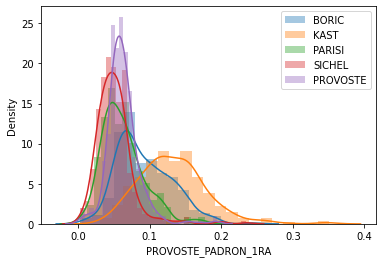

In [67]:
sns.distplot(votaciones['BORIC_PADRON_1RA'], label = 'BORIC')
sns.distplot(votaciones['KAST_PADRON_1RA'], label = 'KAST')
sns.distplot(votaciones['PARISI_PADRON_1RA'], label = 'PARISI')
sns.distplot(votaciones['SICHEL_PADRON_1RA'], label = 'SICHEL')
sns.distplot(votaciones['PROVOSTE_PADRON_1RA'], label = 'PROVOSTE')
plt.legend()

/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


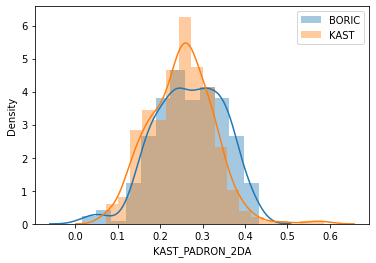

In [68]:
sns.distplot(votaciones['BORIC_PADRON_2DA'], label = 'BORIC')
sns.distplot(votaciones['KAST_PADRON_2DA'], label = 'KAST')
plt.legend()

/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


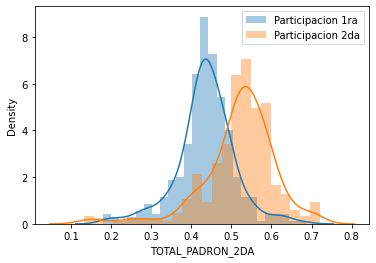

In [69]:
sns.distplot(votaciones['TOTAL_PADRON_1RA'], label = 'Participacion 1ra')
sns.distplot(votaciones['TOTAL_PADRON_2DA'], label = 'Participacion 2da')
plt.legend()

/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matiasfbr/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

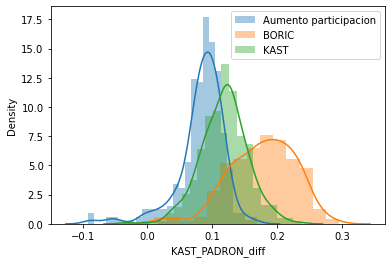

In [70]:
sns.distplot(votaciones['TOTAL_PADRON_diff'], label = 'Aumento participacion')
sns.distplot(votaciones['BORIC_PADRON_diff'], label = 'BORIC')
sns.distplot(votaciones['KAST_PADRON_diff'], label = 'KAST')

plt.legend()

## Carga mapas comunas

In [71]:
chile_gpd = gpd.read_file('comunas/comunas.shp')

In [72]:
chile_gpd

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."
1,29,125730.104795,15,8,6102,6,4.157446e+08,151911.576827,Región del Libertador Bernardo O'Higgins,Codegua,Cachapoal,"POLYGON ((-7831651.813 -4022443.109, -7831596...."
2,30,63026.084422,15,8,6103,6,1.448565e+08,76355.326122,Región del Libertador Bernardo O'Higgins,Coinco,Cachapoal,"POLYGON ((-7892616.357 -4060673.364, -7892621...."
3,31,89840.903562,15,8,6104,6,3.256572e+08,108874.623150,Región del Libertador Bernardo O'Higgins,Coltauco,Cachapoal,"POLYGON ((-7906457.717 -4051723.734, -7906266...."
4,78,122626.493264,23,11,9121,9,6.990727e+08,156680.410681,Región de La Araucanía,Cholchol,Cautín,"POLYGON ((-8121756.186 -4645860.295, -8121644...."
...,...,...,...,...,...,...,...,...,...,...,...,...
341,255,130240.555805,19,10,16305,16,8.751006e+08,160459.137929,Región de Ñuble,San Nicolás,Punilla,"POLYGON ((-8041950.854 -4349201.562, -8041735...."
342,253,311061.932415,19,10,16304,16,2.393007e+09,388109.613857,Región de Ñuble,San Fabián,Punilla,"POLYGON ((-7931328.549 -4363544.179, -7931320...."
343,245,159257.906431,19,10,16303,16,7.638173e+08,195593.933727,Región de Ñuble,Ñiquén,Punilla,"POLYGON ((-8026032.185 -4319505.012, -8025933...."
344,243,157467.049667,19,10,16104,16,1.044405e+09,196962.664313,Región de Ñuble,El Carmen,Ñuble,"POLYGON ((-7986315.104 -4415272.935, -7986309...."


In [73]:
votaciones_gpd = pd.merge(chile_gpd, votaciones, on = 'cod_comuna')

In [74]:
votaciones_gpd.sample(3)

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry,comuna_nombre,TOTAL_PADRON,BORIC_1RA,BORIC_2DA,BORIC_diff,BORIC_PADRON_1RA,BORIC_PADRON_2DA,BORIC_PADRON_diff,KAST_1RA,KAST_2DA,KAST_diff,KAST_PADRON_1RA,KAST_PADRON_2DA,KAST_PADRON_diff,PARISI_PADRON_1RA,SICHEL_PADRON_1RA,PROVOSTE_PADRON_1RA,TOTAL_VOTOS_1RA,TOTAL_VOTOS_2DA,TOTAL_VOTOS_diff,TOTAL_PADRON_1RA,TOTAL_PADRON_2DA,TOTAL_PADRON_diff,TOTAL_PADRON_diff_porc,VOTOS_2DA_1RA,RESULTADO_1RA,RESULTADO_2DA,CAMBIA_GANADOR
28,39,105318.148508,16,8,6113,6,4.718689e+08,127729.924327,Región del Libertador Bernardo O'Higgins,Pichidegua,Cachapoal,"POLYGON ((-7952906.257 -4063105.965, -7952688....",PICHIDEGUA,16858,1541,4977,3436,0.091411,0.295231,0.203820,1614,3626,2012,0.095741,0.215091,0.119350,0.044193,0.067505,0.073081,6817,8603,1786,0.404378,0.510322,0.105944,0.261992,1.261992,0,1,-1.0
108,288,172581.447530,8,7,13301,13,1.386968e+09,206660.187466,Región Metropolitana de Santiago,Colina,Chacabuco,"POLYGON ((-7879353.625 -3919889.834, -7879390....",COLINA,90446,7968,22453,14485,0.088097,0.248248,0.160151,18091,32583,14492,0.200020,0.360248,0.160228,0.044170,0.106373,0.038940,46593,55036,8443,0.515147,0.608496,0.093349,0.181207,1.181207,0,0,0.0
94,226,87754.419245,20,10,8101,8,3.427179e+08,109049.371139,Región del Bío-Bío,Concepción,Concepción,"POLYGON ((-8119582.996 -4406748.017, -8119492....",CONCEPCION,201066,24338,60675,36337,0.121045,0.301767,0.180722,30048,55596,25548,0.149443,0.276506,0.127063,0.063109,0.063278,0.054912,98019,116271,18252,0.487497,0.578273,0.090776,0.186209,1.186209,0,1,-1.0


In [75]:
vmin = votaciones['TOTAL_PADRON_diff_porc'].min()
vmax = votaciones['TOTAL_PADRON_diff_porc'].max()

<AxesSubplot:>

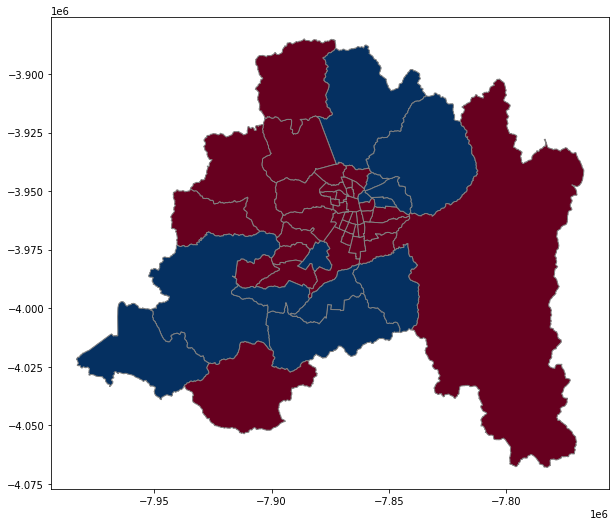

In [76]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
votaciones_gpd[votaciones_gpd['codregion']==13].plot(
    'RESULTADO_1RA',
    cmap = 'RdBu_r',
    edgecolor="gray", 
    ax = ax
)



<AxesSubplot:>

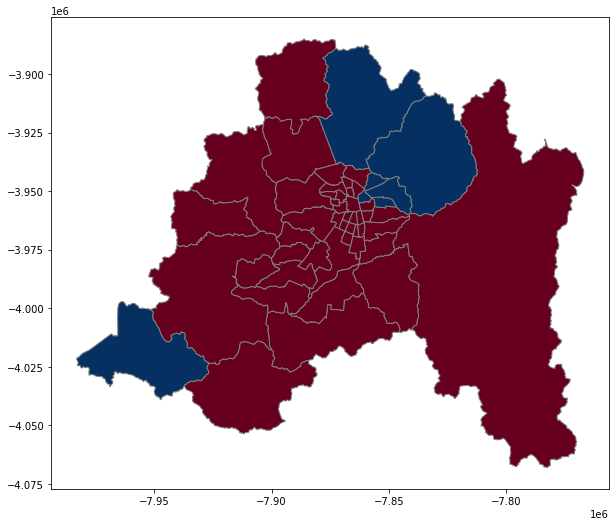

In [77]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
votaciones_gpd[votaciones_gpd['codregion']==13].plot(
    'RESULTADO_2DA',
    cmap = 'RdBu_r',
    edgecolor="gray", 
    ax = ax
)



<AxesSubplot:>

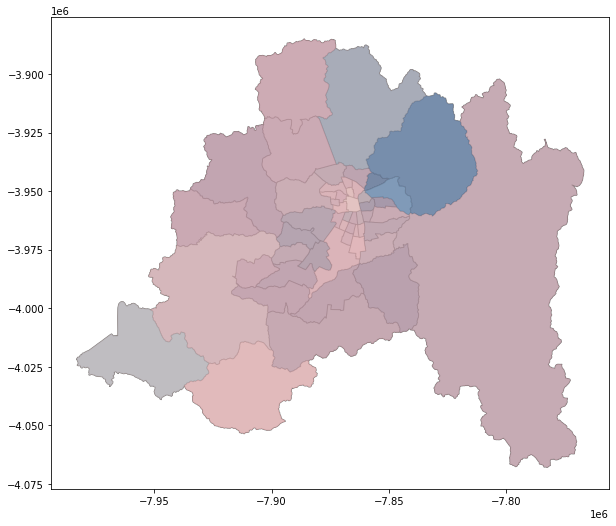

In [78]:
fig, ax = plt.subplots(1,1,figsize = (10,10))
votaciones_gpd[votaciones_gpd['codregion']==13].plot(color = 'lightgray'
                                                           , edgecolor="gray"
                                                           , ax = ax
                                                    )
votaciones_gpd[votaciones_gpd['codregion']==13].plot('BORIC_PADRON_2DA'
                                                     , cmap = 'Reds'
                                                     , ax = ax
                                                     , alpha = 0.5
                                                    )

votaciones_gpd[votaciones_gpd['codregion']==13].plot('KAST_PADRON_2DA'
                                                     , cmap = 'Blues'
                                                     , ax = ax
                                                     , alpha = 0.5
                                                    )



In [79]:
votaciones_gpd['centroid'] = votaciones_gpd['geometry'].centroid

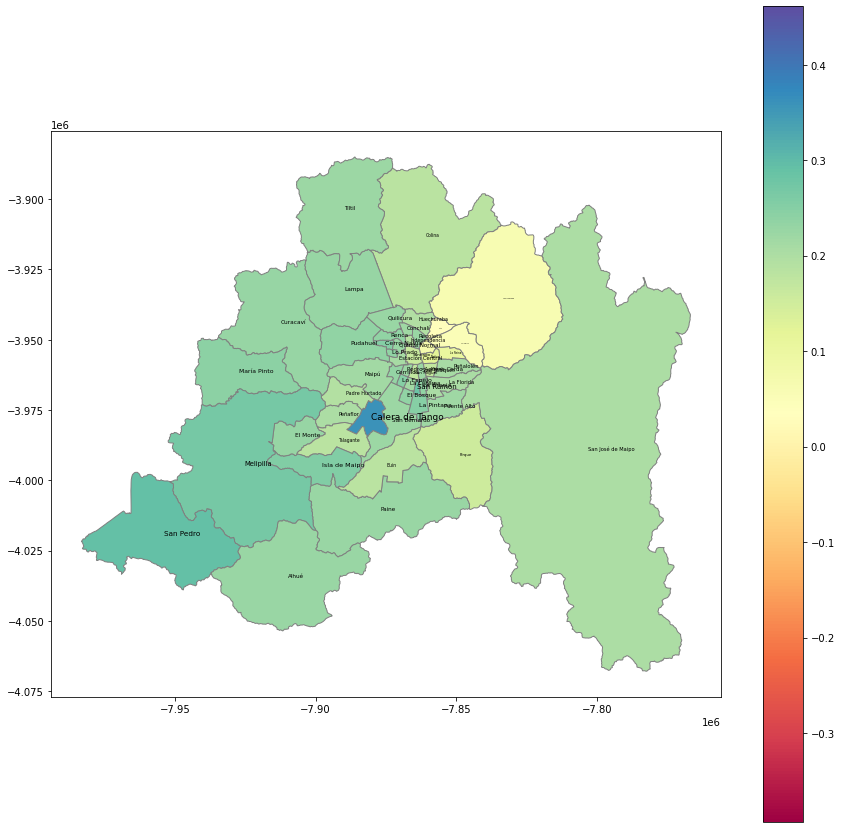

In [80]:
temp = votaciones_gpd[votaciones_gpd['codregion']==13]

fig, ax = plt.subplots(1,1,figsize = (15,15))
temp.plot(
    'TOTAL_PADRON_diff_porc',
    cmap = 'Spectral',
    edgecolor="gray", 
    ax = ax,
    legend = True,
    vmin = vmin,
    vmax = vmax
)

for index, row in temp.iterrows():
    ax.annotate(str(row['Comuna']), xy = (row['centroid'].x, row['centroid'].y), fontsize = 25*abs(row['TOTAL_PADRON_diff_porc']))

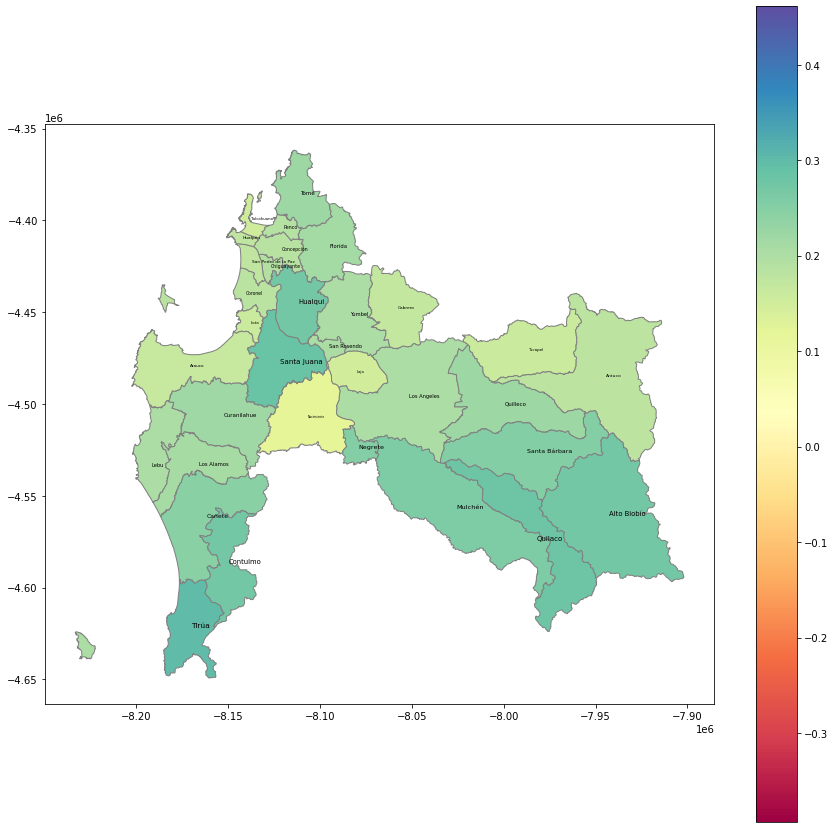

In [81]:
temp = votaciones_gpd[votaciones_gpd['codregion']==8]

fig, ax = plt.subplots(1,1,figsize = (15,15))
temp.plot(
    'TOTAL_PADRON_diff_porc',
    cmap = 'Spectral',
    edgecolor="gray", 
    ax = ax,
    legend = True,
    vmin = vmin,
    vmax = vmax
)

for index, row in temp.iterrows():
    ax.annotate(str(row['Comuna']), xy = (row['centroid'].x, row['centroid'].y), fontsize = 25*abs(row['TOTAL_PADRON_diff_porc']))

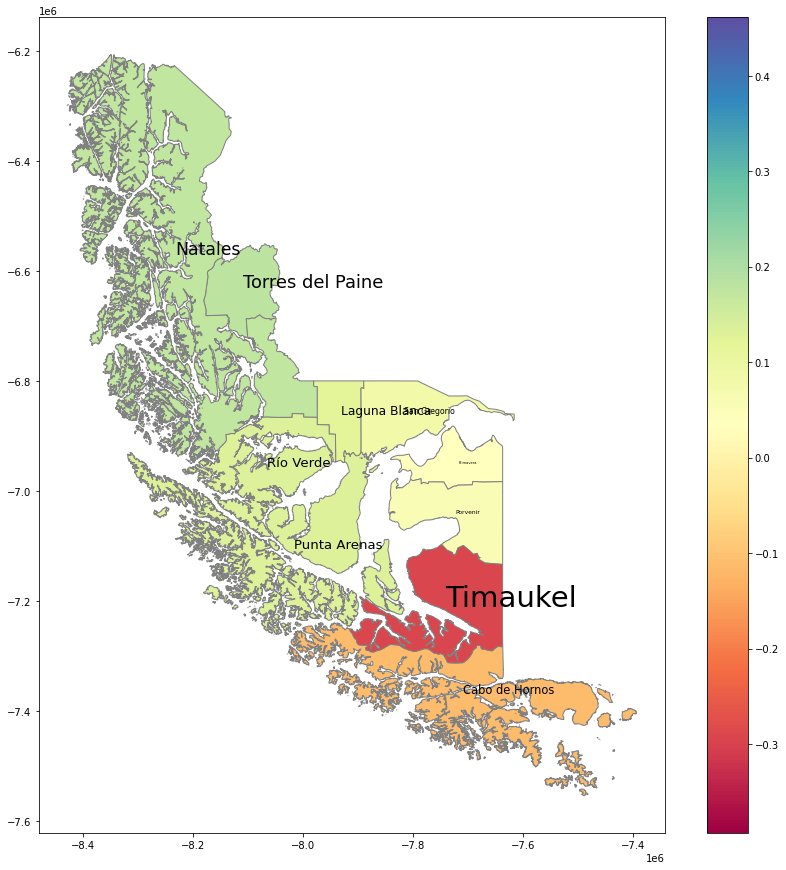

In [82]:
temp = votaciones_gpd[votaciones_gpd['codregion']==12]

fig, ax = plt.subplots(1,1,figsize = (15,15))
temp.plot(
    'TOTAL_PADRON_diff_porc',
    cmap = 'Spectral',
    edgecolor="gray", 
    ax = ax,
    legend = True,
    vmin = vmin,
    vmax = vmax
)

for index, row in temp.iterrows():
    ax.annotate(str(row['Comuna']), xy = (row['centroid'].x, row['centroid'].y), fontsize = 100*abs(row['TOTAL_PADRON_diff_porc']))

## Cambios en la participación total nacional

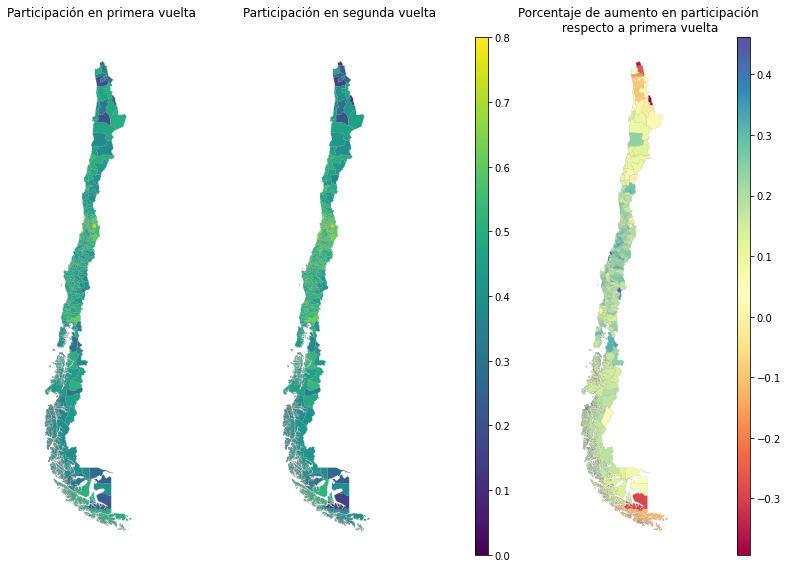

In [83]:
fig, ax = plt.subplots(1,3,figsize = (12,8))
mapa = votaciones_gpd

mapa.plot(
    'TOTAL_PADRON_1RA',
    cmap = 'viridis',
    edgecolor="gray",
    linewidth=0.1,
    ax = ax[0],
    vmin = 0,
    vmax = mapa['TOTAL_PADRON_2DA'].max(),    
)
ax[0].set_xlim(-0.85E7, -0.7E7)
ax[0].set_title('Participación en primera vuelta\n')


divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="10%", pad=1)
mapa.plot(
    'TOTAL_PADRON_2DA',
    cmap = 'viridis',
    edgecolor="gray",
    linewidth=0.1,
    ax = ax[1],
    legend = True,
    vmin = 0,
    vmax = 0.8,
    cax = cax
)
ax[1].set_xlim(-0.85E7, -0.7E7)
ax[1].set_title('Participación en segunda vuelta\n')


divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="10%", pad=0.5)
mapa.plot(
    'TOTAL_PADRON_diff_porc',
    cmap = 'Spectral',
    edgecolor="gray",
    linewidth=0.1,
    ax = ax[2],
    legend = True,
    cax = cax   
)
ax[2].set_xlim(-0.85E7, -0.7E7)
ax[2].set_title('Porcentaje de aumento en participación\n respecto a primera vuelta')


ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()

plt.savefig('cambio_participacion_nacional.png')

## Cambios en la participación RM

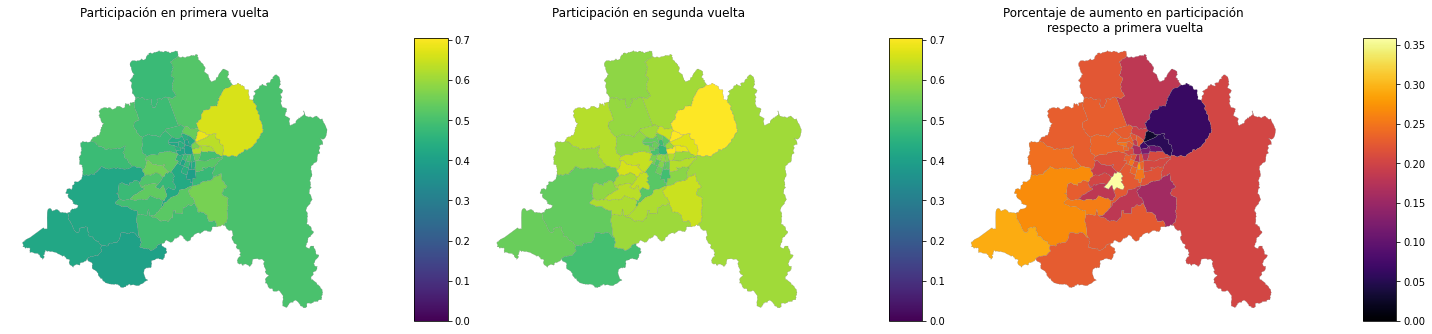

In [84]:
fig, ax = plt.subplots(1,3,figsize = (20,15))
mapa = votaciones_gpd[votaciones_gpd['codregion']==13]

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="10%", pad=1)
mapa.plot(
    'TOTAL_PADRON_1RA',
    cmap = 'viridis',
    edgecolor="gray",
    linewidth=0.2,
    ax = ax[0],
    vmin = 0,
    vmax = mapa['TOTAL_PADRON_2DA'].max(),
    cax = cax,
    legend = True
)

ax[0].set_title('Participación en primera vuelta\n')


divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="10%", pad=1)
mapa.plot(
    'TOTAL_PADRON_2DA',
    cmap = 'viridis',
    edgecolor="gray",
    linewidth=0.2,
    ax = ax[1],
    legend = True,
    vmin = 0,
    
    cax = cax
)

ax[1].set_title('Participación en segunda vuelta\n')


divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="10%", pad=1)
mapa.plot(
    'TOTAL_PADRON_diff_porc',
    cmap = 'inferno',
    edgecolor="gray",
    linewidth=0.2,
    ax = ax[2],
    legend = True,
    cax = cax,
    vmin = 0
)

ax[2].set_title('Porcentaje de aumento en participación\n respecto a primera vuelta')


ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.savefig('cambio_participacion_RM.png')